<a href="https://colab.research.google.com/github/menduv/mtg-Jamendo/blob/main/CNN_mtg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN model for classification of audio files with genre tags

In [1]:
#connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#importing the spectrogram images stored in a zip file
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/colab_data/cropped_archive_22.zip","r") as zip_ref:
    zip_ref.extractall("/content/sample_mel")

In [2]:
#importing necessary libraries
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.models import load_model

In [3]:
#checking the no. of spectrograms and their size
mel_dir = '/content/sample_mel'
mel_list = os.listdir(mel_dir)
mel_npy = np.load(f'{mel_dir}/{mel_list[25]}')
print('Count of npy files: ', len(mel_list))
print('Size of image: ', mel_npy.shape)

Count of npy files:  4480
Size of image:  (96, 1406)


## Loading the mtg dataframe and filtering it to include top 5 genres from the sample

In [4]:
#importing csv that contains the metafile of all the tracks
df_all = pd.read_csv('/content/mtg_cleaned.csv', index_col = [0])

In [5]:
df_all.head()

,track_id,artist_id,album_id,path,duration,genre,instrument,mood
1,214,14,31,14/214.mp3,124.6,punkrock,NaN,NaN
2,215,14,31,15/215.mp3,151.4,metal,NaN,NaN
3,216,14,31,16/216.mp3,234.9,metal,NaN,NaN
4,217,14,31,17/217.mp3,127.9,punkrock,NaN,NaN
5,218,14,31,18/218.mp3,180.7,punkrock,NaN,NaN


In [6]:
#list of all the track_ids in the sample zip file
track_ids = [int(file_name.replace('.npy', '')) for file_name in mel_list]

#filtering only those tracks to the dataset
df = df_all[df_all['track_id'].isin(track_ids)]

#only taking the first genre from the genre column
df['genre'] = df['genre'].str.split(',').str[0]

#only keeping the tracks and genre column
df = df[['track_id', 'genre']]

In [7]:
#calculating the most frequent genres in the sample and only keeping the top five in the df
genre_count = pd.DataFrame(df.genre.value_counts().rename_axis('genre').reset_index(name='counts'))

#list of top five genres
top_genres = list(genre_count.genre[:10])

#filtering df to only keep
df = df[df['genre'].isin(top_genres)].sort_values(by = 'track_id', ascending = True).reset_index(drop = True)

df

,track_id,genre
0,6606,dance
1,6607,dance
2,6608,dance
3,6609,dance
4,6610,dance
...,...,...
3096,1420700,chillout
3097,1420704,dance
3098,1420705,dance
3099,1420706,dance


In [8]:
#List of all the track_ids that are in the sample and have top5
train_track_ids = list(df['track_id'].values)

In [9]:
train_track_ids[:5]

[6606, 6607, 6608, 6609, 6610]

### Cropping mel-spectrograms to the size (96, 1406)

In [ ]:
!mkdir '/content/cropped_mel'

In [ ]:
def crop_melspectrogram(mel_spectrogram, target_frames, hop_size):
    # Crop or pad the mel spectrogram to the target number of frames
    if mel_spectrogram.shape[1] >= target_frames:
        cropped_mel_spectrogram = mel_spectrogram[:, :target_frames]
    else:
        # Pad with zeros if the original length is less than the target
        padding = np.zeros((mel_spectrogram.shape[0], target_frames - mel_spectrogram.shape[1]))
        cropped_mel_spectrogram = np.hstack((mel_spectrogram, padding))

    return cropped_mel_spectrogram


In [ ]:
folder_path = '/content/sample_mel'
cropped_folder_path = '/content/cropped_mel'

# Assuming the hop size used during mel spectrogram calculation
hop_size = 256
sample_rate = 12000

# Calculate the target number of frames based on the desired duration (e.g., 30 seconds)
desired_duration_seconds = 30
target_frames = int(desired_duration_seconds * (1 / (hop_size / sample_rate)))

# Iterate over files in the folder
for filename in train_track_ids:
    file_path = os.path.join(folder_path, str(filename) +'.npy')

    mel_spectrogram = np.load(file_path)

    cropped_mel_spectrogram = crop_melspectrogram(mel_spectrogram, target_frames, hop_size)

    np.save(os.path.join(cropped_folder_path, str(filename)), cropped_mel_spectrogram)

In [ ]:
print('The number of cropped mel-spectrogram in the cropped_mel folder is:',len(os.listdir('/content/cropped_mel')))

The number of cropped mel-spectrogram in the cropped_mel folder is: 1016


In [ ]:
'''To display cropped and original mels'''

# crop_mel_307 = np.load('/content/cropped_mel/1001307.npy')
# mel_307 = np.load('/content/sample_mel/1001307.npy')

# plt.imshow(crop_mel_307, aspect='auto')
# plt.xlabel('Time')
# plt.ylabel('Mel Frequency Bin')
# plt.title('Mel-Spectrogram')
# plt.colorbar()
# plt.show()

# plt.imshow(mel_307, aspect='auto')
# plt.xlabel('Time')
# plt.ylabel('Mel Frequency Bin')
# plt.title('Mel-Spectrogram')
# plt.colorbar()
# plt.show()

# Training the model

In [10]:
#loading the cropped .npy files

folder_path_mel = '/content/sample_mel'
filenames = os.listdir(folder_path_mel)

data = []
i = 0

for filename in train_track_ids:
  filename_npy = str(filename) + '.npy'
  file_path = os.path.join(folder_path_mel, filename_npy)
  data.append(np.load(file_path))
  if i < 10 :
    print(filename)
  i = i+1

data = np.array(data)


6606
6607
6608
6609
6610
6611
6719
6720
6721
6722


In [11]:
#normalize data
data = data.astype('float32')/255.0

In [12]:
# Reshape data to include the channel dimension
data = data.reshape((-1, 96, 1406, 1))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, pd.get_dummies(df['genre']), test_size=0.2, random_state=42)

In [13]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)

In [14]:
# Define num_classes based on the number of unique genres
num_classes = y_train.shape[1]

In [15]:
num_classes

10

In [16]:
# Initialize the model
model = Sequential()

# Convolutional layers with L2 regularization
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 1406, 1), kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layers with L2 regularization
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001)))

# Compile the model (use an appropriate optimizer, loss function, and metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 1404, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 702, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 700, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 350, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 348, 128)      73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 174, 128)      0

In [17]:
# Train model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
78/78 [==============================] - 17s 110ms/step - loss: 2.3279 - accuracy: 0.2290 - val_loss: 2.1028 - val_accuracy: 0.2995
Epoch 2/10
78/78 [==============================] - 4s 57ms/step - loss: 2.1472 - accuracy: 0.2597 - val_loss: 2.0295 - val_accuracy: 0.3092
Epoch 3/10
78/78 [==============================] - 5s 64ms/step - loss: 2.1043 - accuracy: 0.2766 - val_loss: 2.0330 - val_accuracy: 0.3205
Epoch 4/10
78/78 [==============================] - 6s 78ms/step - loss: 2.0815 - accuracy: 0.2827 - val_loss: 2.0059 - val_accuracy: 0.3188
Epoch 5/10
78/78 [==============================] - 4s 54ms/step - loss: 2.0505 - accuracy: 0.3000 - val_loss: 1.9744 - val_accuracy: 0.3269
Epoch 6/10
78/78 [==============================] - 4s 48ms/step - loss: 2.0253 - accuracy: 0.3073 - val_loss: 1.9443 - val_accuracy: 0.3027
Epoch 7/10
78/78 [==============================] - 4s 54ms/step - loss: 2.0175 - accuracy: 0.3065 - val_loss: 1.9424 - val_accuracy: 0.3172
Epoch 8/10


In [18]:
# Train for 10 more epochs
history_20 = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), initial_epoch=10)

Epoch 11/20
78/78 [==============================] - 5s 60ms/step - loss: 1.9595 - accuracy: 0.3383 - val_loss: 1.9076 - val_accuracy: 0.3430
Epoch 12/20
78/78 [==============================] - 4s 51ms/step - loss: 1.9510 - accuracy: 0.3339 - val_loss: 1.8945 - val_accuracy: 0.3478
Epoch 13/20
78/78 [==============================] - 4s 52ms/step - loss: 1.9369 - accuracy: 0.3448 - val_loss: 1.9046 - val_accuracy: 0.3349
Epoch 14/20
78/78 [==============================] - 4s 53ms/step - loss: 1.9133 - accuracy: 0.3415 - val_loss: 1.8901 - val_accuracy: 0.3446
Epoch 15/20
78/78 [==============================] - 4s 47ms/step - loss: 1.8859 - accuracy: 0.3589 - val_loss: 1.8736 - val_accuracy: 0.3462
Epoch 16/20
78/78 [==============================] - 4s 51ms/step - loss: 1.8644 - accuracy: 0.3794 - val_loss: 1.9014 - val_accuracy: 0.3527
Epoch 17/20
78/78 [==============================] - 4s 53ms/step - loss: 1.8364 - accuracy: 0.4016 - val_loss: 1.8811 - val_accuracy: 0.3752
Epoch 

In [19]:
# Train for 10 more epochs
history_30 = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), initial_epoch=20)

Epoch 21/30
78/78 [==============================] - 5s 60ms/step - loss: 1.6865 - accuracy: 0.4665 - val_loss: 2.0387 - val_accuracy: 0.3430
Epoch 22/30
78/78 [==============================] - 4s 52ms/step - loss: 1.6301 - accuracy: 0.5028 - val_loss: 2.0122 - val_accuracy: 0.3704
Epoch 23/30
78/78 [==============================] - 4s 50ms/step - loss: 1.5887 - accuracy: 0.5040 - val_loss: 2.1033 - val_accuracy: 0.3897
Epoch 24/30
78/78 [==============================] - 4s 56ms/step - loss: 1.5515 - accuracy: 0.5306 - val_loss: 2.1509 - val_accuracy: 0.3688
Epoch 25/30
78/78 [==============================] - 4s 48ms/step - loss: 1.4960 - accuracy: 0.5544 - val_loss: 2.2919 - val_accuracy: 0.3543
Epoch 26/30
78/78 [==============================] - 4s 47ms/step - loss: 1.4816 - accuracy: 0.5617 - val_loss: 2.2638 - val_accuracy: 0.3784
Epoch 27/30
78/78 [==============================] - 4s 55ms/step - loss: 1.4155 - accuracy: 0.6016 - val_loss: 2.3850 - val_accuracy: 0.3865
Epoch 

In [20]:
history_40 = model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_val, y_val), initial_epoch=30)

Epoch 31/40
78/78 [==============================] - 5s 59ms/step - loss: 1.2635 - accuracy: 0.6532 - val_loss: 2.6011 - val_accuracy: 0.3768
Epoch 32/40
78/78 [==============================] - 4s 48ms/step - loss: 1.2113 - accuracy: 0.6738 - val_loss: 2.6935 - val_accuracy: 0.3881
Epoch 33/40
78/78 [==============================] - 4s 54ms/step - loss: 1.2051 - accuracy: 0.6891 - val_loss: 2.8459 - val_accuracy: 0.3591
Epoch 34/40
78/78 [==============================] - 4s 52ms/step - loss: 1.2020 - accuracy: 0.6940 - val_loss: 2.7579 - val_accuracy: 0.3720
Epoch 35/40
78/78 [==============================] - 4s 48ms/step - loss: 1.1584 - accuracy: 0.7117 - val_loss: 2.9358 - val_accuracy: 0.3671
Epoch 36/40
78/78 [==============================] - 4s 52ms/step - loss: 1.1588 - accuracy: 0.7040 - val_loss: 2.9260 - val_accuracy: 0.3784
Epoch 37/40
78/78 [==============================] - 4s 54ms/step - loss: 1.1176 - accuracy: 0.7198 - val_loss: 3.0753 - val_accuracy: 0.3623
Epoch 

In [21]:
# Save the model
model.save('/content/drive/MyDrive/colab_data/cnn_3k_l20.001_40ep.keras')

In [22]:
# Load the model
loaded_model = load_model('/content/drive/MyDrive/colab_data/cnn_3k_l20.001_40ep.keras')

In [ ]:
# Compile the model with the appropriate optimizer, loss, and metrics
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# last val loss and val acc
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

20/20 [==============================] - 0s 18ms/step - loss: 3.2048 - accuracy: 0.3623
Validation Loss: 3.2048299312591553, Validation Accuracy: 0.36231884360313416


In [24]:
# Concatenate the old and new history
full_history = {}
for key in history.history.keys():
    full_history[key] = history.history[key] + history_20.history[key] + history_30.history[key] + history_40.history[key]

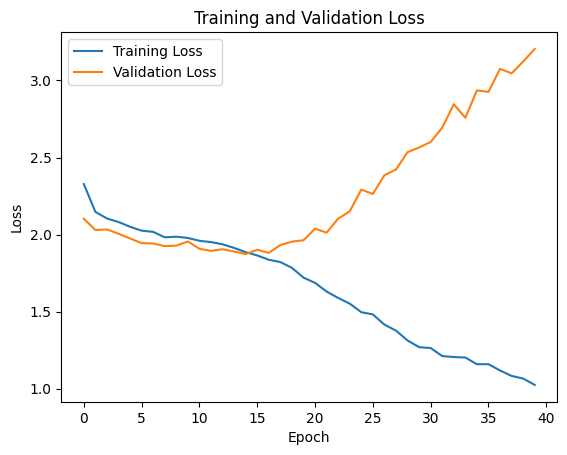

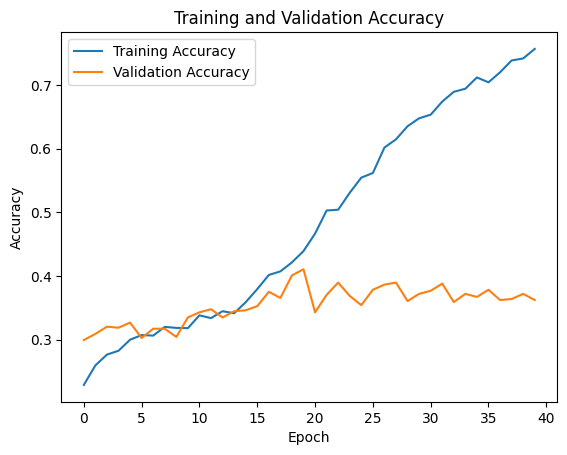

In [25]:
# Plot training loss
plt.plot(full_history['loss'], label='Training Loss')
plt.plot(full_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(full_history['accuracy'], label='Training Accuracy')
plt.plot(full_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


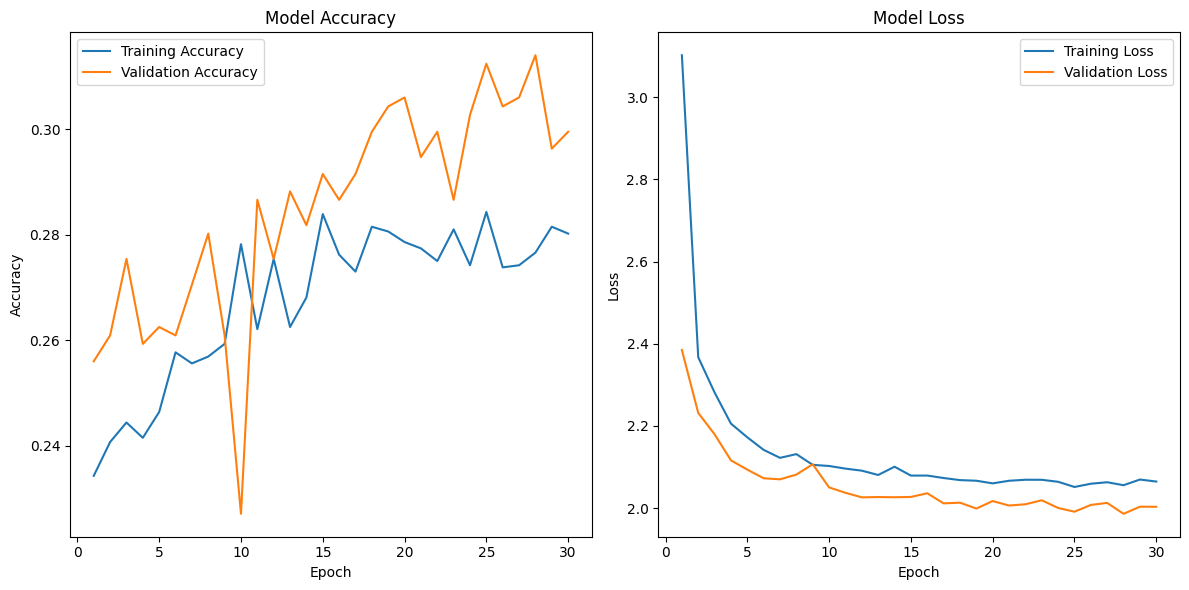

In [ ]:
# import matplotlib.pyplot as plt

# # Define the data
# epochs = list(range(1, 31))  # Assuming 30 epochs
# train_loss = [3.1024, 2.3673, 2.2814, 2.2056, 2.1723, 2.1417, 2.1223, 2.1314, 2.1052, 2.1025, 2.0961, 2.0911, 2.0806, 2.1007, 2.0791, 2.0792, 2.0732, 2.0681, 2.0666, 2.0602, 2.0665, 2.0690, 2.0689, 2.0640, 2.0514, 2.0593, 2.0629, 2.0557, 2.0695, 2.0646]
# val_loss = [2.3848, 2.2317, 2.1796, 2.1162, 2.0936, 2.0726, 2.0700, 2.0816, 2.1067, 2.0504, 2.0372, 2.0261, 2.0269, 2.0264, 2.0271, 2.0361, 2.0115, 2.0132, 1.9988, 2.0171, 2.0062, 2.0093, 2.0190, 2.0003, 1.9912, 2.0077, 2.0126, 1.9861, 2.0034, 2.0032]
# train_accuracy = [0.2343, 0.2407, 0.2444, 0.2415, 0.2464, 0.2577, 0.2556, 0.2569, 0.2593, 0.2782, 0.2621, 0.2754, 0.2625, 0.2681, 0.2839, 0.2762, 0.2730, 0.2815, 0.2806, 0.2786, 0.2774, 0.2750, 0.2810, 0.2742, 0.2843, 0.2738, 0.2742, 0.2766, 0.2815, 0.2802]
# val_accuracy = [0.2560, 0.2609, 0.2754, 0.2593, 0.2625, 0.2609, 0.2705, 0.2802, 0.2609, 0.2271, 0.2866, 0.2754, 0.2882, 0.2818, 0.2915, 0.2866, 0.2915, 0.2995, 0.3043, 0.3060, 0.2947, 0.2995, 0.2866, 0.3027, 0.3124, 0.3043, 0.3060, 0.3140, 0.2963, 0.2995]

# # Plot training & validation accuracy values
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_accuracy, label='Training Accuracy')
# plt.plot(epochs, val_accuracy, label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# # Plot training & validation loss values
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_loss, label='Training Loss')
# plt.plot(epochs, val_loss, label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()


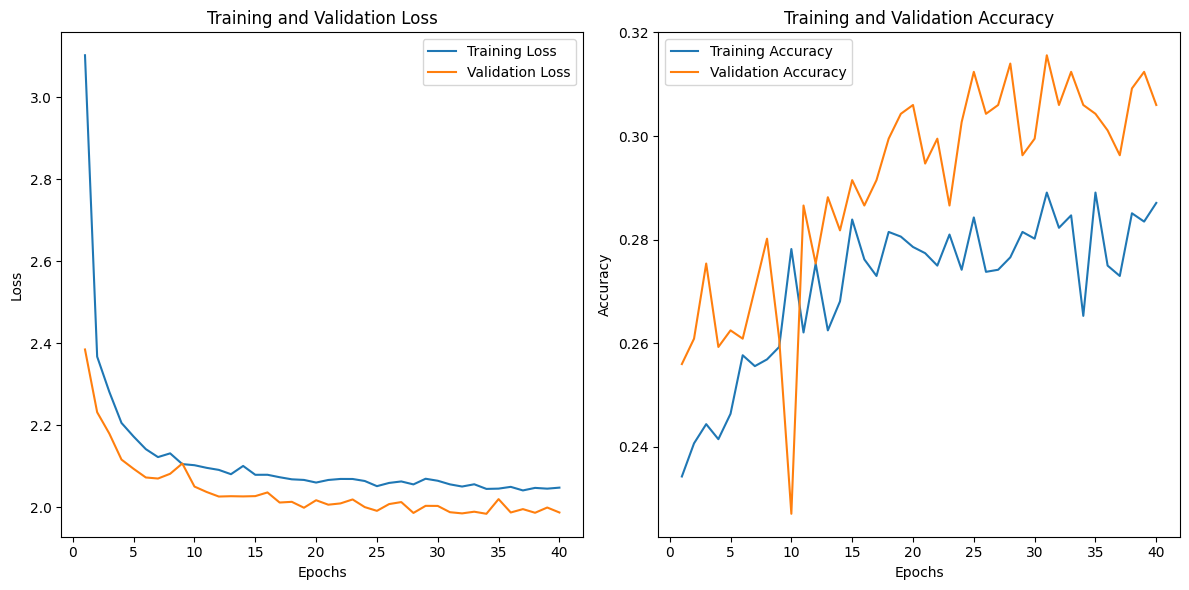

In [ ]:
# # Extend the data
# epochs.extend(list(range(31, 41)))
# train_loss.extend([2.0558, 2.0505, 2.0560, 2.0447, 2.0454, 2.0497, 2.0410, 2.0472, 2.0453, 2.0478])
# val_loss.extend([1.9879, 1.9850, 1.9891, 1.9840, 2.0198, 1.9872, 1.9954, 1.9865, 1.9993, 1.9872])
# train_accuracy.extend([0.2891, 0.2823, 0.2847, 0.2653, 0.2891, 0.2750, 0.2730, 0.2851, 0.2835, 0.2871])
# val_accuracy.extend([0.3156, 0.3060, 0.3124, 0.3060, 0.3043, 0.3011, 0.2963, 0.3092, 0.3124, 0.3060])

# # Plot the data
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))

# # Loss plot
# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_loss, label='Training Loss')
# plt.plot(epochs, val_loss, label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # Accuracy plot
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_accuracy, label='Training Accuracy')
# plt.plot(epochs, val_accuracy, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()


In [ ]:
#This was without l2 reg

'''
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 1406, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional layers to fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Introducing dropout for regularization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Introducing dropout for regularization

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary for an overview of the architecture
model.summary()'''

In [ ]:
'''
import keras
# Save the entire model to a file
model.save('/content/drive/MyDrive/colab_data/simple_cnn_3kmel.keras')

# Load the model back
loaded_model = keras.models.load_model('/content/drive/MyDrive/colab_data/simple_cnn_3kmel.keras')'''

In [ ]:
'''
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
'''